## Imports and Loading

In [51]:
!pip install rembg==2.0.56 -q

In [52]:
import os
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from rembg import new_session, remove
from sklearn.metrics.pairwise import cosine_similarity

In [53]:
def find_images_and_load(directory):
    image_extensions = ['.jpg', '.jpeg', '.png']
    image_paths = []
    images = []

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    image_paths.append(image_path)
                    images.append(image)

    return image_paths, images

directory_path = '/kaggle/input/key-images/'
image_paths, images = find_images_and_load(directory_path)

print(f"Found {len(image_paths)} image files.")

Found 72 image files.


## Image Pipeline

In [54]:
def plot_image(image, cmap="gray"):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    plt.axis('on')
    plt.show()

class ImageProcessor:
    """Processes images by removing backgrounds, enhancing contrast, and aligning them"""

    def __init__(self, model_name="isnet-general-use"):
        self.session = new_session(model_name)

    def contrast_using_dynamic_gamma(self, image):
        """Adjusts image contrast based on mean intensity"""
        mean_intensity = np.mean(image)
        gamma = 2.5 if mean_intensity < 50 else 2.0 if mean_intensity < 100 else 1.5 if mean_intensity < 150 else 1.7 if mean_intensity < 200 else 0.5
        table = np.array([(i / 255) ** (1 / gamma) * 255 for i in range(256)], dtype="uint8")
        return cv2.LUT(image, table), gamma

    def get_grayed_image(self, image):
        """Converts image to grayscale and adjusts its contrast"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return self.contrast_using_dynamic_gamma(gray_image)[0]

    def remove_bg(self, input_img, only_mask=False):
        """Removes the background of the image using the model session"""
        return remove(data=input_img, only_mask=only_mask, session=self.session)

    def get_skeleton_and_contour(self, image):
        """Extracts the largest contour and creates a skeleton image"""
        gray_mask = np.array(self.remove_bg(image, only_mask=True))
        _, bin_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        largest_contour = max(contours, key=cv2.contourArea)
        skeleton = np.zeros_like(image, dtype=np.uint8)
        thickness = (skeleton.shape[0] + skeleton.shape[1]) // 200
        cv2.drawContours(skeleton, [largest_contour], -1, 255, thickness)
        
        return skeleton, largest_contour

    def straighten_and_crop(self, image, contour):
        """Crops the image to the bounding box of the largest contour and straightens it"""
        x, y, w, h = cv2.boundingRect(contour)
        cropped_image = image[y:y+h, x:x+w]

        orientation = 'vertical' if h > w else 'horizontal'
        points = {
            'leftmost': tuple(contour[contour[:, :, 0].argmin()][0]),
            'rightmost': tuple(contour[contour[:, :, 0].argmax()][0]),
            'topmost': tuple(contour[contour[:, :, 1].argmin()][0]),
            'bottommost': tuple(contour[contour[:, :, 1].argmax()][0])
        }

        if orientation == 'vertical':
            center = ((points['leftmost'][0] + points['rightmost'][0]) // 2, 
                      (points['leftmost'][1] + points['rightmost'][1]) // 2)
            endpoint = points['topmost']
        else:
            center = ((points['topmost'][0] + points['bottommost'][0]) // 2, 
                      (points['topmost'][1] + points['bottommost'][1]) // 2)
            endpoint = points['rightmost']

        angle = math.degrees(math.atan2(endpoint[1] - center[1], endpoint[0] - center[0]))
        h, w = cropped_image.shape[:2]
        new_w = int(h * abs(math.sin(math.radians(angle))) + w * abs(math.cos(math.radians(angle))))
        new_h = int(h * abs(math.cos(math.radians(angle))) + w * abs(math.sin(math.radians(angle))))

        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        M[0, 2] += (new_w / 2) - (w // 2)
        M[1, 2] += (new_h / 2) - (h // 2)

        return cv2.warpAffine(cropped_image, M, (new_w, new_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    def resize_with_padding(self, image):
        """Resizes the image to 256x256 with 12 pixels of padding"""
        h, w = image.shape[:2]
        size = max(h, w)
        square_image = np.zeros((size, size), dtype=np.uint8)
        if h > w:
            offset = (h - w) // 2
            square_image[:, offset:offset+w] = image
        else:
            offset = (w - h) // 2
            square_image[offset:offset+h, :] = image

        resized_image = cv2.resize(square_image, (232, 232))
        return cv2.copyMakeBorder(resized_image, 12, 12, 12, 12, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    def process(self, rgb_image):
        """Complete processing pipeline: graying, skeletonizing, straightening, cropping, resizing, and displaying the image"""
        gray_image = self.get_grayed_image(np.array(rgb_image))
        skeleton, largest_contour = self.get_skeleton_and_contour(gray_image)
        straightened_cropped_image = self.straighten_and_crop(skeleton, largest_contour)
        final_image = self.resize_with_padding(straightened_cropped_image)
        return final_image


In [55]:
from tqdm import tqdm

processed = []
processor = ImageProcessor()

for image in tqdm(images, desc='Processing images', unit='image'):
    processed_image = processor.process(image)
    processed.append(processed_image)

Processing images: 100%|██████████| 72/72 [03:45<00:00,  3.14s/image]


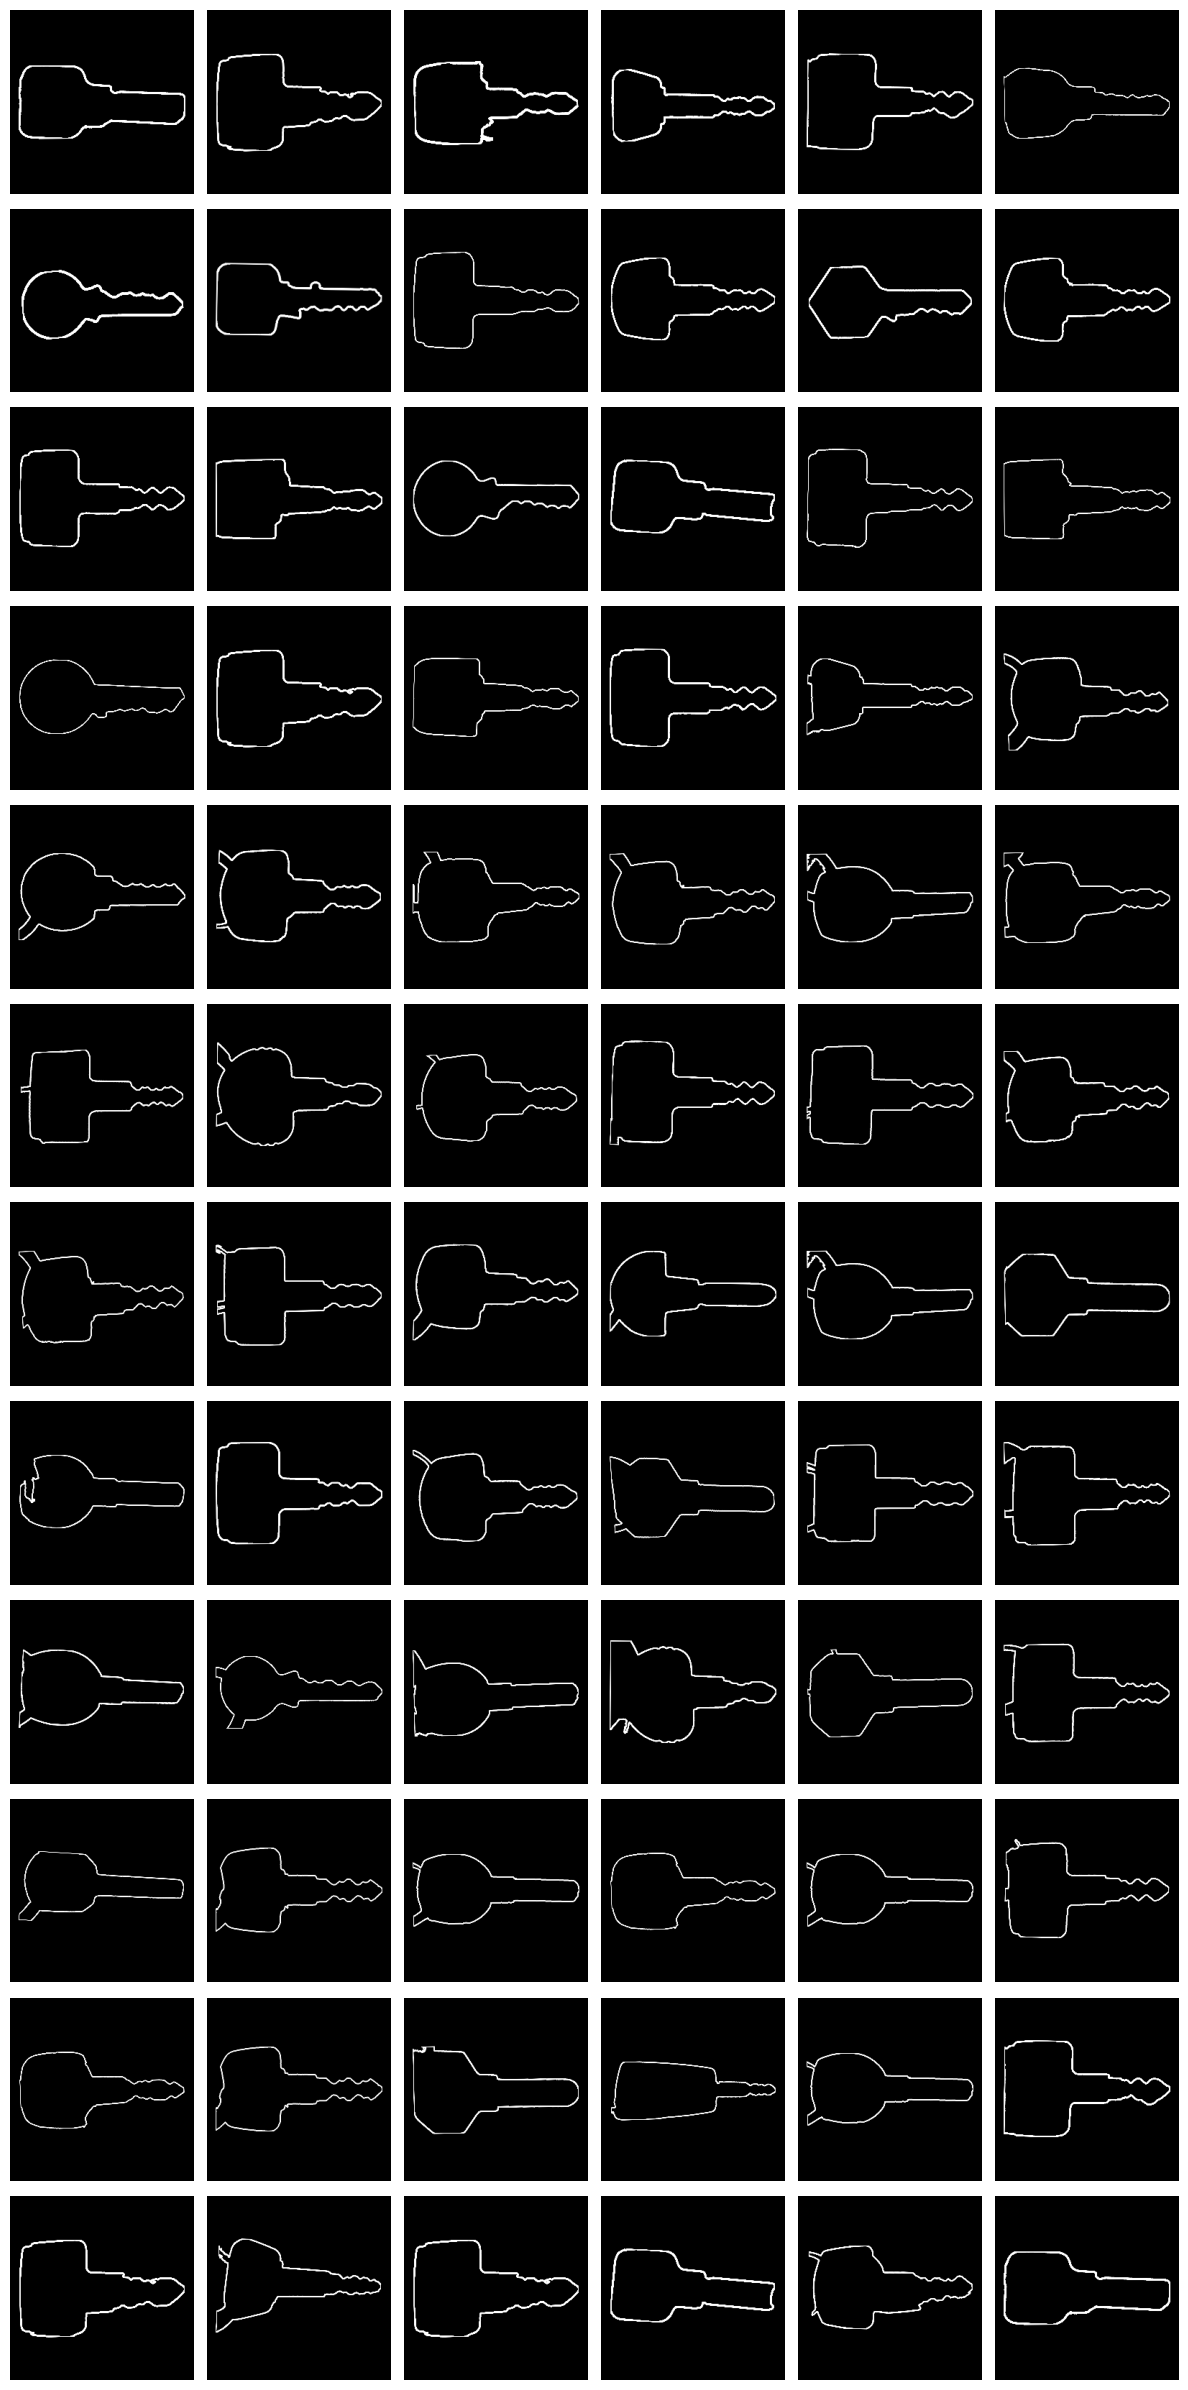

In [56]:
images_per_row = 6
num_images = len(processed)
num_rows = num_images // images_per_row

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each image in the grid
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(processed[i], cmap='gray')
        ax.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()